In [1]:
## Code updated from RandomWalk_2020-04-01.jl

In [1]:
using Pkg;
Pkg.activate(".")

"/Users/mcfefa/Dropbox/Papers in Progress/Diversity-Score-Theory-Paper/code/Project.toml"

In [2]:
using Random
using Plots
using Statistics

┌ Info: Recompiling stale cache file /Users/mcfefa/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [3]:
using Dates

In [19]:
using Serialization

In [59]:
using DataFrames

┌ Info: Recompiling stale cache file /Users/mcfefa/.julia/compiled/v1.0/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1184


In [86]:
using CSV

┌ Info: Recompiling stale cache file /Users/mcfefa/.julia/compiled/v1.0/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184


In [4]:
## Create initial conditions
   # input: number of cells, initial clones, will randomly assign initial frequency 

function makeInitialPayoff(clones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    # ... is vararg splat, takes an array of values and passes them to a function as if 1st, 2nd, 3rd
    # converts an array into arguments

    if freqSel
      payoff = fillPayoff.*rand(clones,clones)
    else
      payoff = hcat(fill(fillPayoff, (clones,1))...)
    end
    
    return payoff::Matrix
end


makeInitialPayoff (generic function with 2 methods)

In [5]:
function initialize(cellCount::Int64, numClones::Int64, fillPayoff::Vector, freqSel::Bool=false)
    # initialize what each cell is 
    
    totalCells = rand(1:numClones,cellCount); # assigning clones to each spot
    payoff = makeInitialPayoff(numClones, fillPayoff, freqSel)
    
    return (totalCells, payoff); 
end

initialize (generic function with 2 methods)

In [6]:
function calcFreq(uniqueClones::Vector{Int64}, perClone::Vector{Int64})
    # calculates frequency of each unique clone at current time point
    
    ### ASK JAMES FOR A WORD DESCRIPTION OF X->X=i ...
    
    cts = [count(x->x==i,perClone) for i in uniqueClones]
    return cts/sum(cts)
end

calcFreq (generic function with 1 method)

In [7]:
## Create payoff matrix -- add row/column

function makeNewClone(mtx::Matrix, parent::Int64, freqSel::Bool=false)
    
    ## add or delete depending on if new clone is added or removed from population
    # to add, make a new matrix of [n+1, n+1], loop through to fill in old matrix and add new matrix
    
    # note, should be a square matrix, x==y --- use for error handling
    
    (x,y) = size(mtx)
    newMtx = zeros(x+1,x+1)   # creates an empty matrix of zeros
    newMtx[1:x,1:x] = mtx     # fills in the original matrix
    
    if freqSel
        # FREQUENCY SELECTION
        # returns clone that will produce the new clone
        # perturb by the mean with std proportional to mean
        newMtx[x+1,1:x] = mtx[parent,:].*(1 .+ 0.01*randn(x))      
        ## fill last elements of row 
        # calculate the mean of the rows to fill in for the new clone 
        rowMean = mean(newMtx[1:x,1:x],dims=2)
        for i in 1:x
            newMtx[i,x+1] = rowMean[i]
        end
    else
        # CONSTANT SELECTION 
        newOne = mtx[parent,1]*(1+randn()) # all the same across the row, 
        newMtx[x+1,:] = fill(newOne,x+1)   # fill in constant selection for new species
        for i in 1:x
              newMtx[i,x+1] = newMtx[i,x]
        end
    end 
    
    return newMtx/maximum(newMtx)
end

makeNewClone (generic function with 2 methods)

In [8]:
## Create payoff matrix -- remove row/column

function deleteClone(mtx::Matrix{Float64}, remove::Int64)
    
    ## add or delete depending on if new clone is added or removed from population
    # to delete, just delete row and column of interest
    
    return mtx[1:end .!= remove, 1:end .!= remove]
end


deleteClone (generic function with 1 method)

In [9]:
function calcAvgFitness(payoff::Matrix{Float64}, freq::Vector{Float64})
    # multiply the frequencies by the payoff matrix to calculate the average fitness   
    # xT*A*x
    
    expectedPayoff = payoff*freq
    
    # return (transpose(freq)*Epayoff, Epayoff) 
    return (freq'*expectedPayoff, expectedPayoff) 
end

calcAvgFitness (generic function with 1 method)

In [10]:
function probReplication(payoff::Matrix{Float64}, freq::Vector{Float64}, intensity::Float64)
    
    # calculating the probability that a clone replicates
    # inputs: payoff matrix (Matrix)
    #         frequency of the clones (Vector)
    #         selection intensity (Real)
    # output: probability 
    
    (avg, expectedPayoff) = calcAvgFitness(payoff,freq);

    # Species rate of production of offspring
    probRep = exp.(intensity*(expectedPayoff)).*freq  #  .- avg
    # @show probRep

    # Compute CDF
    cs = cumsum(probRep)
    prob = cs/cs[end]
    
    # returns grouping of which proportion will be replicating when random number
    return prob
end

probReplication (generic function with 1 method)

In [11]:
function calcqD(freq::Vector{Float64}, res::Int64=1000)
  ## good default resoluion: 1000
  ## TO DO: add if q == 1 correction 

  q = exp10.(range(-2.0, stop=2.0, length=res));
  qD = sum(freq.^q', dims=1) .^ (1 ./ (1 .- q'))
  return (qD[:], q)
end

calcqD (generic function with 2 methods)

In [12]:
function runSim(initialPayoff::Vector{Float64}, totGen::Int64, cellCount::Int64, numClones::Int64, intensity::Float64, mutProb::Float64, howOftenCalcQD::Int64, resQD::Int64=1000, freqSelOn::Bool=false)
    
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   delay::Int64 - after delay steps, start calculating qD  !!!! TO DO !!!!
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    
    # Create the initial payoff matrix, based on cellCount & numClones
    # initialize the initial conditions
    # make individual cells with which clone they are and the initial payoff matrix
    (cells, payoff) = initialize(cellCount, numClones, initialPayoff, freqSelOn);
    totClones = numClones;
    uniqueClones = Array(1:numClones)
    numClonesTrack = zeros(Int,totGen);
    numClonesTrack[1] = numClones;
    
    # create array for collecting --- ASK JAMES IF THIS CAN BE IMPROVED ---- ask James what means 
    qDarray = Vector{Float64}[]

    # calculate the frequency of each clone
    freq = calcFreq(uniqueClones,cells)
    qD, qRange = calcqD(freq);
    push!(qDarray, qD)
    whoDied = Tuple{Int, Float64}[]
    
    for gen in 2:totGen

        # Step 1: calculate prob of each clone to be replicating
        # Step 2: find which clone replicates (random number, see who select)
        # Step 3: decide if mutate (rand num)
        # Step 4: decide how much mutates by (offspring close to num in payoff)
   
        # get a cumulative probability distribution (essentially CDF) for probability of replication
        CDF = probReplication(payoff, freq, intensity) 

        # decide which clone replicates
        ####### FIXME ###### (When only single clone )
        roll = rand()
        
        whichOneRep = []
        whichOneRepIndex = []
        try
            # looking for the first time we exceed the role, if so mutates
            whichOneRepIndex = findall(y->(y>=roll),CDF)[1]
            whichOneRep = uniqueClones[whichOneRepIndex]
        catch
            @show freq, payoff, uniqueClones,CDF
            @error("what??")
        end
        
       # println("which one reps ", whichOneRep)
        #once replication occurs, does it mutated
        if (mutProb > rand())
            ## true, add to payoff matrix
            # if you mutate, update payoff, update array of cells and add new cell to total num of clones
            payoff = makeNewClone(payoff, whichOneRepIndex, freqSelOn) 
            numClones +=1
            totClones +=1
            whoReplacesDead = totClones
            push!(uniqueClones, whoReplacesDead)
        else
            ## false - no mutation
            whoReplacesDead = whichOneRep
        end
                    
        # randomly pick who dies (randomly pick a clone, replace with new clone)
        whichCellDies = rand(1:cellCount)
        cells[whichCellDies] = whoReplacesDead
        
        # check to see if a clone is lost --> 0 is a lost clone
        # calculate the frequency of each clone to identify 0 clone
        freq = calcFreq(uniqueClones,cells)
                
        # check if we lost a clone, if yes       
        locZeros = findall(x->x==0,freq)
        # if clone died, record it in whoDied and remove from payoff
        if length(locZeros) > 0
            
            deadClone = locZeros[1]
            # record which clone died and its payoff
            push!(whoDied, (uniqueClones[deadClone], payoff[deadClone,1]))     
            
            # delete dead clone from payoff, freq, and number of clones
            payoff = deleteClone(payoff, deadClone)
            deleteat!(freq,deadClone)
            deleteat!(uniqueClones,deadClone)
            numClones -= 1
            
        end
        
        numClonesTrack[gen] = numClones; 
        if gen % howOftenCalcQD == 0
          qD, _ = calcqD(freq);
          push!(qDarray, qD)
        end
    end
   # currently only returning first column of payoff matrix because all rows are the same
    return (numClonesTrack=numClonesTrack, totClones=totClones, freq=freq, payoff=payoff[:,1], whoDied=whoDied, qD=qDarray, q=qRange)
    
end

runSim (generic function with 3 methods)

In [13]:
    # inputs: 
    #   initialPayoff::Vector{Float64} - fill vector 
    #   totGen::Int64 - number of generations to loop over
    #   cellCount::Int64 - total number of cells/total population size
    #   numClones::Int64 - number of distinct clones
    #   intensity::Float64 - selection intensity
    #   mutProb:: Float64 - probability a clone mutates 
    #   howOftenCalcQD::Int64 - calculate qD every howOftenCalcQD timesteps
    #   resQD::Int64 - resolution at which qD is calculated, defaults to 1000 
    #   freqSelOn::Bool = tells whether on freq dependent selection or constant selection

In [14]:
# outputs: (
#       numClonesTrack=numClonesTrack, 
#       totClones=totClones, 
#       freq=freq, 
#       payoff=payoff[:,1], 
#       whoDied=whoDied, 
#       qD=qDarray, q=qRange
# )

In [15]:
numClones = 1;
mut = 2.0e-3;
cellCount = 1000;
initialPayoff = rand(numClones);
gen=500000;
selInt = 10.0;
howOften = 10000;
resolution = 10000;
freqSelType = false;

In [16]:
resConstSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);

In [17]:
resFreqSel = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [27]:
###### Saving results in Julia
## using Serialization
## to save
## open(fileOut, "w") do fp
##    serialize(fp, x)
##  end
## to get back out
## x = open(fileIn, "r") do fp
##    deserialize(fp, x)
##  end

In [29]:
fileOut1 = string("SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_",Dates.today(),".dat")
open(fileOut1, "w") do fp
    serialize(fp, resConstSel)
end

In [30]:
fileOut2 = string("SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_",Dates.today(),".dat")
open(fileOut2, "w") do fp
    serialize(fp, resFreqSel)
end

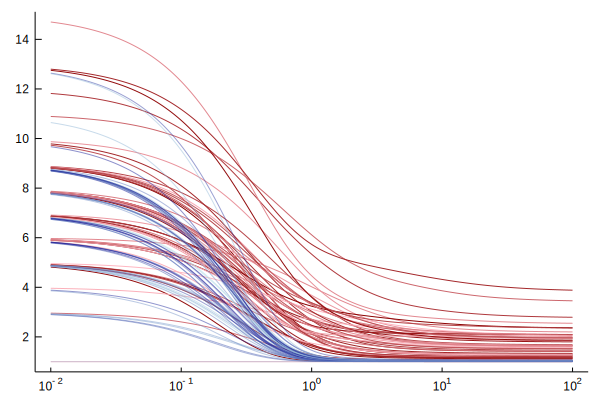

In [31]:
# plot qD curve: 
qdPlot = plot(resConstSel.q,resConstSel.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot, resFreqSel.q,resFreqSel.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)

In [32]:
savefig(qdPlot, string("DiversityCurves_selInt-10_mutRate-2e-3_",Dates.today(),".pdf"))

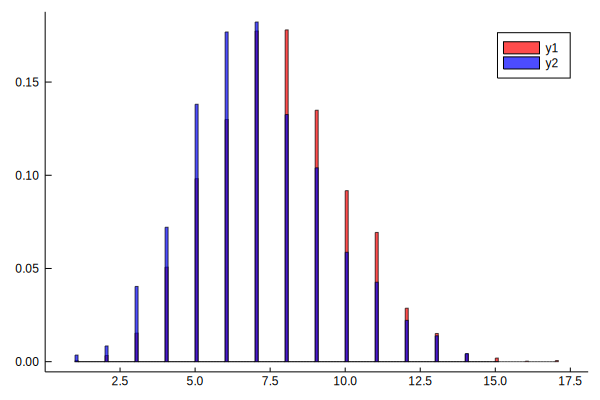

In [33]:
# histogram of number of clones at a time
hPlot = histogram(resConstSel.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlot, resFreqSel.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7)

In [34]:
savefig(hPlot, string("Histogram-of-Clones_selInt-10_mutRate-2e-3_",Dates.today(),".pdf"))

In [83]:
function calcDivDF(q, qD)
    # create a dataframe with top diversity metrics we look at: lowq, highq, deltaqD, IPq, IP slope
    
    # step 1: create empty vectors
    lowTmp = zeros(length(qD))
    highTmp = zeros(length(qD))
    deltaTmp = zeros(length(qD))
    IPtmp = zeros(length(qD),2)
    
    # loop through all diversity curves generated in simulation
    for i in 1:length(qD)
        lowTmp[i] = qD[i][1]    # record low q diversity, q=0.01
        highTmp[i] = qD[i][end] # record high q diversity, q=100
        deltaTmp[i] = qD[i][1] - qD[i][end]  # calculate delta qD diversity
        IPq, IPm = reportInflection(q, qD[i]) # find and calculated IP q and slope
        IPtmp[i,1] = IPq; # inflection point q and slope to respective locations
        IPtmp[i,2] = IPm;
    end
    
    # compile together into a single dataframe
    dfDiv = DataFrame(lowQ=lowTmp, highQ=highTmp, deltaqD=deltaTmp, IPq=IPtmp[:,1], IPslope=IPtmp[:,2])
    
    return dfDiv; 
    
end


calcDivDF (generic function with 1 method)

In [84]:
## inflection point calculation supporting functions

function findInflection(q::Array, qD::Array)
    approxLogDeriv = q[2:end].*diff(qD)./diff(q);
    return approxLogDeriv; 
end

function findInflectionLocal(approx::Array)
    return argmin((approx))
end

function reportInflection(q::Array, qD::Array)
    diffVector = findInflection(q, qD)
    inflectPt = findInflectionLocal(diffVector)
    slopeInflectPt = abs(diffVector[inflectPt])
    qInflecPt = q[inflectPt+1]
    return (qInflecPt, slopeInflectPt)
end

reportInflection (generic function with 1 method)

In [85]:
constSelDivDF = calcDivDF(resConstSel.q, resConstSel.qD)
first(constSelDivDF,3)

,lowQ,highQ,deltaqD,IPq,IPslope
,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,0.0100926,0.0
2,8.80544,1.26238,7.54306,0.34797,2.73185
3,7.82618,1.25918,6.567,0.344776,2.25615


In [168]:
fileOutDF1 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1,constSelDivDF)

"./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_2020-06-02.csv"

In [89]:
freqSelDivDF = calcDivDF(resFreqSel.q, resFreqSel.qD)
first(freqSelDivDF,3)

,lowQ,highQ,deltaqD,IPq,IPslope
,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,0.0100926,0.0
2,6.7599,1.01331,5.74659,0.225607,2.37361
3,4.87914,1.04761,3.83153,0.289375,1.50007


In [167]:
fileOutDF2 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2,freqSelDivDF)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-2e-3_gen-500k_2020-06-02.csv"

In [91]:
numClones = 1;
mut = 2.0e-3;
cellCount = 1000;
initialPayoff = rand(numClones);
gen=500000;
selInt = 5.0;
howOften = 10000;
resolution = 10000;
freqSelType = false;
resConstSel_2en3mut_int5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel_2en3mut_int5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [92]:
fileOutA = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-2e-3_gen-500k_",Dates.today(),".dat")
open(fileOutA, "w") do fp
    serialize(fp, resConstSel_2en3mut_int5)
end
fileOutB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-2e-3_gen-500k_",Dates.today(),".dat")
open(fileOutB, "w") do fp
    serialize(fp, resFreqSel_2en3mut_int5)
end

In [166]:
constSelDivDF_2en3mut_int5 = calcDivDF(resConstSel_2en3mut_int5.q, resConstSel_2en3mut_int5.qD)
freqSelDivDF_2en3mut_int5 = calcDivDF(resFreqSel_2en3mut_int5.q, resFreqSel_2en3mut_int5.qD)

fileOutDF1A = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-2e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1A,constSelDivDF_2en3mut_int5)

fileOutDF2B = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-2e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2B,freqSelDivDF_2en3mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-2e-3_gen-500k_2020-06-02.csv"

In [94]:
# plot qD curve: 
qdPlot2 = plot(resConstSel_2en3mut_int5.q,resConstSel_2en3mut_int5.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot2, resFreqSel_2en3mut_int5.q,resFreqSel_2en3mut_int5.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot2, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-2e-3_",Dates.today(),".pdf"))

In [95]:
# histogram of number of clones at a time
hPlot2 = histogram(resConstSel_2en3mut_int5.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlot2, resFreqSel_2en3mut_int5.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7)
savefig(hPlot2, string("Histogram-of-Clones_selInt-5_mutRate-2e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 2e-1; Selection: 5

In [97]:
mut = 2.0e-1;
resConstSelHiMu_2en1mut_int5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelHiMu_2en1mut_int5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [98]:
fileOutHiMuA = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-2e-1_gen-500k_",Dates.today(),".dat")
open(fileOutHiMuA, "w") do fp
    serialize(fp, resConstSelHiMu_2en1mut_int5)
end
fileOutHiMuB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-2e-1_gen-500k_",Dates.today(),".dat")
open(fileOutHiMuB, "w") do fp
    serialize(fp, resFreqSelHiMu_2en1mut_int5)
end

In [165]:
constSelDivDF_2en1mut_int5 = calcDivDF(resConstSelHiMu_2en1mut_int5.q, resConstSelHiMu_2en1mut_int5.qD)
freqSelDivDF_2en1mut_int5 = calcDivDF(resFreqSelHiMu_2en1mut_int5.q, resFreqSelHiMu_2en1mut_int5.qD)

fileOutDF1HiMuA = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-2e-1_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1HiMuA,constSelDivDF_2en1mut_int5)

fileOutDF2HiMuB = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-2e-1_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2HiMuB,freqSelDivDF_2en1mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-2e-1_gen-500k_2020-06-02.csv"

In [100]:
# plot qD curve: 
qdPlot3 = plot(resConstSelHiMu_2en1mut_int5.q,resConstSelHiMu_2en1mut_int5.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot3, resFreqSelHiMu_2en1mut_int5.q,resFreqSelHiMu_2en1mut_int5.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot3, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-2e-1_",Dates.today(),".pdf"))

In [101]:
# histogram of number of clones at a time
hPlot3 = histogram(resConstSelHiMu_2en1mut_int5.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlot3, resFreqSelHiMu_2en1mut_int5.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7)
savefig(hPlot3, string("Histogram-of-Clones_selInt-5_mutRate-2e-1_",Dates.today(),".pdf"))

#### Mutation Rate: 2e-1; Selection: 10

In [109]:
selInt = 10.0;
resConstSelHiMu_2en1mut_int10 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelHiMu_2en1mut_int10 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [110]:
fileOutHiMuA2 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-2e-1_gen-500k_",Dates.today(),".dat")
open(fileOutHiMuA2, "w") do fp
    serialize(fp, resConstSelHiMu_2en1mut_int10)
end
fileOutHiMuB2 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-2e-1_gen-500k_",Dates.today(),".dat")
open(fileOutHiMuB2, "w") do fp
    serialize(fp, resFreqSelHiMu_2en1mut_int10)
end

In [164]:
constSelDivDF_2en1mut_int10 = calcDivDF(resConstSelHiMu_2en1mut_int10.q, resConstSelHiMu_2en1mut_int10.qD)
freqSelDivDF_2en1mut_int10 = calcDivDF(resFreqSelHiMu_2en1mut_int10.q, resFreqSelHiMu_2en1mut_int10.qD)

fileOutDF1HiMuA2 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-2e-1_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1HiMuA2,constSelDivDF_2en1mut_int10)

fileOutDF2HiMuB2 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-2e-1_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2HiMuB2,freqSelDivDF_2en1mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-2e-1_gen-500k_2020-06-02.csv"

In [112]:
# plot qD curve: 
qdPlot4 = plot(resConstSelHiMu_2en1mut_int10.q,resConstSelHiMu_2en1mut_int10.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot4, resFreqSelHiMu_2en1mut_int10.q,resFreqSelHiMu_2en1mut_int10.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot4, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-2e-1_",Dates.today(),".pdf"))

In [113]:
# histogram of number of clones at a time
hPlot4 = histogram(resConstSelHiMu_2en1mut_int10.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.7, grid=false)
histogram!(hPlot4, resFreqSelHiMu_2en1mut_int10.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.7)
savefig(hPlot4, string("Histogram-of-Clones_selInt-10_mutRate-2e-1_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-4; Selection: 10

In [114]:
mut = 5e-4;
sel = 10.0; 
resConstSelLoMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelLoMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [115]:
fileOutLoMuA = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutLoMuA, "w") do fp
    serialize(fp, resConstSelLoMu2)
end
fileOutLoMuB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutLoMuB, "w") do fp
    serialize(fp, resFreqSelLoMu2)
end

In [163]:
constSelDivDF_5en4mut_int10 = calcDivDF(resConstSelLoMu2.q, resConstSelLoMu2.qD)
freqSelDivDF_5en4mut_int10 = calcDivDF(resFreqSelLoMu2.q, resFreqSelLoMu2.qD)

fileOutDF1LoMu = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1LoMu,constSelDivDF_5en4mut_int10)

fileOutDF2LoMu = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2LoMu,freqSelDivDF_5en4mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-4_gen-500k_2020-06-02.csv"

In [117]:
# plot qD curve: 
qdPlotLoMu2 = plot(resConstSelLoMu2.q,resConstSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotLoMu2, resFreqSelLoMu2.q,resFreqSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotLoMu2, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-5e-4_",Dates.today(),".pdf"))

In [118]:
# histogram of number of clones at a time
hPlotLoMu2 = histogram(resConstSelLoMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:red, linealpha=0.2, opacity=0.6, grid=false)
histogram!(hPlotLoMu2, resFreqSelLoMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, linealpha=0.2, opacity=0.6, legend=false)
savefig(hPlotLoMu2, string("./results/Moran-process/Histogram-of-Clones_selInt-10_mutRate-5e-4_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-4; Selection: 5

In [119]:
mut = 5e-4;
sel = 5.0; 
resConstSelLoMu2B = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelLoMu2B = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [120]:
fileOutLoMuAB = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutLoMuAB, "w") do fp
    serialize(fp, resConstSelLoMu2B)
end
fileOutLoMuBB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutLoMuB, "w") do fp
    serialize(fpB, resFreqSelLoMu2B)
end

UndefVarError: UndefVarError: fpB not defined

In [162]:
constSelDivDF_5en4mut_int5 = calcDivDF(resConstSelLoMu2B.q, resConstSelLoMu2B.qD)
freqSelDivDF_5en4mut_int5 = calcDivDF(resFreqSelLoMu2B.q, resFreqSelLoMu2B.qD)

fileOutDF1LoMuB = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1LoMuB,constSelDivDF_5en4mut_int5)

fileOutDF2LoMuB = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2LoMuB,freqSelDivDF_5en4mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-4_gen-500k_2020-06-02.csv"

In [122]:
# plot qD curve: 
qdPlotLoMu2B = plot(resConstSelLoMu2B.q,resConstSelLoMu2B.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotLoMu2B, resFreqSelLoMu2B.q,resFreqSelLoMu2B.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotLoMu2B, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-5e-4_",Dates.today(),".pdf"))

In [123]:
# histogram of number of clones at a time
hPlotLoMu2B = histogram(resConstSelLoMu2B.numClonesTrack, bins=:scott, normalize=:probability, color=:red, linealpha=0.2, opacity=0.6, grid=false)
histogram!(hPlotLoMu2B, resFreqSelLoMu2B.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, linealpha=0.2, opacity=0.6, legend=false)
savefig(hPlotLoMu2B, string("./results/Moran-process/Histogram-of-Clones_selInt-5_mutRate-5e-4_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-2; Selection: 10

In [124]:
mut = 5e-2;
sel = 10.0; 
resConstSelHiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelHiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [125]:
fileOutHiMu2A = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutHiMu2A, "w") do fp
    serialize(fp, resConstSelHiMu2)
end
fileOutHiMu2B = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutHiMu2B, "w") do fp
    serialize(fp, resFreqSelHiMu2)
end

In [161]:
constSelDivDF_5en2mut_int10 = calcDivDF(resConstSelHiMu2.q, resConstSelHiMu2.qD)
freqSelDivDF_5en2mut_int10 = calcDivDF(resFreqSelHiMu2.q, resFreqSelHiMu2.qD)

fileOutDF1HiMu = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1HiMu,constSelDivDF_5en2mut_int10)

fileOutDF2HiMu = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2HiMu,freqSelDivDF_5en2mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-2_gen-500k_2020-06-02.csv"

In [127]:
# plot qD curve: 
qdPlotHiMu2 = plot(resConstSelHiMu2.q,resConstSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu2, resFreqSelHiMu2.q,resFreqSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotHiMu2, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-5e-2_",Dates.today(),".pdf"))

In [128]:
# histogram of number of clones at a time
hPlotHiMu2 = histogram(resConstSelHiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotHiMu2, resFreqSelHiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotHiMu2, string("./results/Moran-process/Histogram-of-Clones_selInt-10_mutRate-5e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-2; Selection: 5

In [129]:
mut = 5e-2;
sel = 5.0; 
resConstSelHiMu2B = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelHiMu2B = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [130]:
fileOutHiMu2AB = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutHiMu2AB, "w") do fp
    serialize(fp, resConstSelHiMu2B)
end
fileOutHiMu2BB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutHiMu2BB, "w") do fp
    serialize(fp, resFreqSelHiMu2B)
end

In [160]:
constSelDivDF_5en2mut_int5 = calcDivDF(resConstSelHiMu2B.q, resConstSelHiMu2B.qD)
freqSelDivDF_5en2mut_int5 = calcDivDF(resFreqSelHiMu2B.q, resFreqSelHiMu2B.qD)

fileOutDF1HiMuB = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1HiMuB,constSelDivDF_5en2mut_int5)

fileOutDF2HiMuB = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2HiMuB,freqSelDivDF_5en2mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-2_gen-500k_2020-06-02.csv"

In [132]:
# plot qD curve: 
qdPlotHiMu2B = plot(resConstSelHiMu2B.q,resConstSelHiMu2B.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu2B, resFreqSelHiMu2B.q,resFreqSelHiMu2B.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotHiMu2B, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-5e-2_",Dates.today(),".pdf"))

In [133]:
# histogram of number of clones at a time
hPlotHiMu2B = histogram(resConstSelHiMu2B.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotHiMu2B, resFreqSelHiMu2B.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotHiMu2B, string("./results/Moran-process/Histogram-of-Clones_selInt-5_mutRate-5e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-3; Sel=10

In [134]:
mut = 1e-3;
sel = 10.0; 
resConstSelMiMu = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [135]:
fileOutMiMuA = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA, "w") do fp
    serialize(fp, resConstSelMiMu)
end
fileOutMiMuB = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB, "w") do fp
    serialize(fp, resFreqSelMiMu)
end

In [159]:
constSelDivDF_1en3mut_int10 = calcDivDF(resConstSelMiMu.q, resConstSelMiMu.qD)
freqSelDivDF_1en3mut_int10 = calcDivDF(resFreqSelMiMu.q, resFreqSelMiMu.qD)

fileOutDF1MiMu = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu,constSelDivDF_1en3mut_int10)

fileOutDF2MiMu = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu,freqSelDivDF_1en3mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-1e-3_gen-500k_2020-06-02.csv"

In [137]:
# plot qD curve: 
qdPlotMiMu = plot(resConstSelMiMu.q,resConstSelMiMu.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu, resFreqSelMiMu.q,resFreqSelMiMu.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-1e-3_",Dates.today(),".pdf"))

In [138]:
# histogram of number of clones at a time
hPlotMiMu = histogram(resConstSelMiMu.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu, resFreqSelMiMu.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu, string("./results/Moran-process/Histogram-of-Clones_selInt-10_mutRate-1e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-3; Sel=5

In [139]:
mut = 1e-3;
sel = 5.0; 
resConstSelMiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu2 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [140]:
fileOutMiMuA2 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA2, "w") do fp
    serialize(fp, resConstSelMiMu2)
end
fileOutMiMuB2 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB2, "w") do fp
    serialize(fp, resFreqSelMiMu2)
end

In [158]:
constSelDivDF_1en3mut_int5 = calcDivDF(resConstSelMiMu2.q, resConstSelMiMu2.qD)
freqSelDivDF_1en3mut_int5 = calcDivDF(resFreqSelMiMu2.q, resFreqSelMiMu2.qD)

fileOutDF1MiMu2 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu2,constSelDivDF_1en3mut_int5)

fileOutDF2MiMu2 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu2,freqSelDivDF_1en3mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-1e-3_gen-500k_2020-06-02.csv"

In [144]:
# plot qD curve: 
qdPlotMiMu2 = plot(resConstSelMiMu2.q,resConstSelMiMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu2, resFreqSelMiMu2.q,resFreqSelMiMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu2, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-1e-3_",Dates.today(),".pdf"))

In [145]:
# histogram of number of clones at a time
hPlotMiMu2 = histogram(resConstSelMiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu2, resFreqSelMiMu2.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu2, string("./results/Moran-process/Histogram-of-Clones_selInt-5_mutRate-1e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-2; Sel=10

In [146]:
mut = 1e-2;
sel = 10.0; 
resConstSelMiMu3 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu3 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [147]:
fileOutMiMuA3 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA3, "w") do fp
    serialize(fp, resConstSelMiMu3)
end
fileOutMiMuB3 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB3, "w") do fp
    serialize(fp, resFreqSelMiMu3)
end

In [157]:
constSelDivDF_1en2mut_int10 = calcDivDF(resConstSelMiMu3.q, resConstSelMiMu3.qD)
freqSelDivDF_1en2mut_int10 = calcDivDF(resFreqSelMiMu3.q, resFreqSelMiMu3.qD)

fileOutDF1MiMu3 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu3,constSelDivDF_1en2mut_int10)

fileOutDF2MiMu3 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu3,freqSelDivDF_1en2mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-1e-2_gen-500k_2020-06-02.csv"

In [149]:
# plot qD curve: 
qdPlotMiMu3 = plot(resConstSelMiMu3.q,resConstSelMiMu3.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu3, resFreqSelMiMu3.q,resFreqSelMiMu3.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu3, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-1e-2_",Dates.today(),".pdf"))

In [150]:
# histogram of number of clones at a time
hPlotMiMu3 = histogram(resConstSelMiMu3.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu3, resFreqSelMiMu3.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu3, string("./results/Moran-process/Histogram-of-Clones_selInt-10_mutRate-1e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-2; Sel=5

In [151]:
mut = 1e-2;
sel = 5.0; 
resConstSelMiMu4 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu4 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [152]:
fileOutMiMuA4 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA4, "w") do fp
    serialize(fp, resConstSelMiMu4)
end
fileOutMiMuB4 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB4, "w") do fp
    serialize(fp, resFreqSelMiMu4)
end

In [156]:
constSelDivDF_1en2mut_int5 = calcDivDF(resConstSelMiMu4.q, resConstSelMiMu4.qD)
freqSelDivDF_1en2mut_int5 = calcDivDF(resFreqSelMiMu4.q, resFreqSelMiMu4.qD)

fileOutDF1MiMu4 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu4,constSelDivDF_1en2mut_int5)

fileOutDF2MiMu4 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu4,freqSelDivDF_1en2mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-1e-2_gen-500k_2020-06-02.csv"

In [154]:
# plot qD curve: 
qdPlotMiMu4 = plot(resConstSelMiMu4.q,resConstSelMiMu4.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu4, resFreqSelMiMu4.q,resFreqSelMiMu4.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu4, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-1e-2_",Dates.today(),".pdf"))

In [155]:
# histogram of number of clones at a time
hPlotMiMu4 = histogram(resConstSelMiMu4.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu4, resFreqSelMiMu4.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu4, string("./results/Moran-process/Histogram-of-Clones_selInt-5_mutRate-1e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-3; Sel=10

In [170]:
mut = 5e-3;
sel = 10.0; 
resConstSelMiMu5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu5 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [171]:
fileOutMiMuA5 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-10_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA5, "w") do fp
    serialize(fp, resConstSelMiMu5)
end
fileOutMiMuB5 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-10_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB5, "w") do fp
    serialize(fp, resFreqSelMiMu5)
end

In [172]:
constSelDivDF_5en3mut_int10 = calcDivDF(resConstSelMiMu5.q, resConstSelMiMu5.qD)
freqSelDivDF_5en3mut_int10 = calcDivDF(resFreqSelMiMu5.q, resFreqSelMiMu5.qD)

fileOutDF1MiMu5 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-10_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu5,constSelDivDF_5en3mut_int10)

fileOutDF2MiMu5 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu5,freqSelDivDF_5en3mut_int10)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-10_mutRate-5e-3_gen-500k_2020-06-02.csv"

In [173]:
# plot qD curve: 
qdPlotMiMu5 = plot(resConstSelMiMu5.q,resConstSelMiMu5.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu5, resFreqSelMiMu5.q,resFreqSelMiMu5.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu5, string("./results/Moran-process/DiversityCurves_selInt-10_mutRate-5e-3_",Dates.today(),".pdf"))

In [174]:
# histogram of number of clones at a time
hPlotMiMu5 = histogram(resConstSelMiMu5.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu5, resFreqSelMiMu5.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu5, string("./results/Moran-process/Histogram-of-Clones_selInt-10_mutRate-5e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-3; Sel=5

In [175]:
mut = 5e-3;
sel = 5.0; 
resConstSelMiMu6 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSelMiMu6 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [176]:
fileOutMiMuA6 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-5_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuA6, "w") do fp
    serialize(fp, resConstSelMiMu6)
end
fileOutMiMuB6 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-5_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutMiMuB6, "w") do fp
    serialize(fp, resFreqSelMiMu6)
end

In [177]:
constSelDivDF_5en3mut_int5 = calcDivDF(resConstSelMiMu6.q, resConstSelMiMu6.qD)
freqSelDivDF_5en3mut_int5 = calcDivDF(resFreqSelMiMu6.q, resFreqSelMiMu6.qD)

fileOutDF1MiMu6 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-5_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1MiMu6,constSelDivDF_5en3mut_int5)

fileOutDF2MiMu6 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2MiMu6,freqSelDivDF_5en3mut_int5)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-5_mutRate-5e-3_gen-500k_2020-06-02.csv"

In [178]:
# plot qD curve: 
qdPlotMiMu6 = plot(resConstSelMiMu6.q,resConstSelMiMu6.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu6, resFreqSelMiMu6.q,resFreqSelMiMu6.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlotMiMu6, string("./results/Moran-process/DiversityCurves_selInt-5_mutRate-5e-3_",Dates.today(),".pdf"))

In [179]:
# histogram of number of clones at a time
hPlotMiMu6 = histogram(resConstSelMiMu6.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlotMiMu6, resFreqSelMiMu6.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlotMiMu6, string("./results/Moran-process/Histogram-of-Clones_selInt-5_mutRate-5e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-4; Sel=1

In [180]:
mut = 5e-4;
sel = 1.0; 
resConstSel7 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel7 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [181]:
fileOutA7 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-1_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutA7, "w") do fp
    serialize(fp, resConstSel7)
end
fileOutB7 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-1_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutB7, "w") do fp
    serialize(fp, resFreqSel7)
end

In [182]:
constSelDivDF_5en4mut_int1 = calcDivDF(resConstSel7.q, resConstSel7.qD)
freqSelDivDF_5en4mut_int1 = calcDivDF(resFreqSel7.q, resFreqSel7.qD)

fileOutDF1_7 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-1_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_7,constSelDivDF_5en4mut_int1)

fileOutDF2_7 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_7,freqSelDivDF_5en4mut_int1)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-4_gen-500k_2020-06-02.csv"

In [183]:
# plot qD curve: 
qdPlot7 = plot(resConstSel7.q,resConstSel7.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot7, resFreqSel7.q,resFreqSel7.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot7, string("./results/Moran-process/DiversityCurves_selInt-1_mutRate-5e-4_",Dates.today(),".pdf"))

In [184]:
# histogram of number of clones at a time
hPlot7 = histogram(resConstSel7.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot7, resFreqSel7.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot7, string("./results/Moran-process/Histogram-of-Clones_selInt-1_mutRate-5e-4_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-3; Sel=1

In [185]:
mut = 5e-3;
sel = 1.0; 
resConstSel8 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel8 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [186]:
fileOutA8 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-1_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutA8, "w") do fp
    serialize(fp, resConstSel8)
end
fileOutB8 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-1_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutB8, "w") do fp
    serialize(fp, resFreqSel8)
end

In [187]:
constSelDivDF_5en3mut_int1 = calcDivDF(resConstSel8.q, resConstSel8.qD)
freqSelDivDF_5en3mut_int1 = calcDivDF(resFreqSel8.q, resFreqSel8.qD)

fileOutDF1_8 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-1_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_8,constSelDivDF_5en3mut_int1)

fileOutDF2_8 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_8,freqSelDivDF_5en3mut_int1)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-3_gen-500k_2020-06-02.csv"

In [188]:
# plot qD curve: 
qdPlot8 = plot(resConstSel8.q,resConstSel8.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot8, resFreqSel8.q,resFreqSel8.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot8, string("./results/Moran-process/DiversityCurves_selInt-1_mutRate-5e-3_",Dates.today(),".pdf"))

In [189]:
# histogram of number of clones at a time
hPlot8 = histogram(resConstSel8.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot8, resFreqSel8.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot8, string("./results/Moran-process/Histogram-of-Clones_selInt-1_mutRate-5e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-2; Sel=1

In [190]:
mut = 5e-2;
sel = 1.0; 
resConstSel9 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel9 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [191]:
fileOutA9 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-1_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutA9, "w") do fp
    serialize(fp, resConstSel9)
end
fileOutB9 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-1_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutB9, "w") do fp
    serialize(fp, resFreqSel9)
end

In [192]:
constSelDivDF_5en2mut_int1 = calcDivDF(resConstSel9.q, resConstSel9.qD)
freqSelDivDF_5en2mut_int1 = calcDivDF(resFreqSel9.q, resFreqSel9.qD)

fileOutDF1_9 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-1_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_9,constSelDivDF_5en2mut_int1)

fileOutDF2_9 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_9,freqSelDivDF_5en2mut_int1)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-5e-2_gen-500k_2020-06-02.csv"

In [193]:
# plot qD curve: 
qdPlot9 = plot(resConstSel9.q,resConstSel9.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot9, resFreqSel9.q,resFreqSel9.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot9, string("./results/Moran-process/DiversityCurves_selInt-1_mutRate-5e-2_",Dates.today(),".pdf"))

In [194]:
# histogram of number of clones at a time
hPlot9 = histogram(resConstSel9.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot9, resFreqSel9.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot9, string("./results/Moran-process/Histogram-of-Clones_selInt-1_mutRate-5e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-2; Sel=1

In [195]:
mut = 1e-2;
sel = 1.0; 
resConstSel10 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel10 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [196]:
fileOutA10 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-1_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutA10, "w") do fp
    serialize(fp, resConstSel10)
end
fileOutB10 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-1_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutB10, "w") do fp
    serialize(fp, resFreqSel10)
end

In [197]:
constSelDivDF_1en2mut_int1 = calcDivDF(resConstSel10.q, resConstSel10.qD)
freqSelDivDF_1en2mut_int1 = calcDivDF(resFreqSel10.q, resFreqSel10.qD)

fileOutDF1_10 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-1_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_10,constSelDivDF_1en2mut_int1)

fileOutDF2_10 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_10,freqSelDivDF_1en2mut_int1)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-1e-2_gen-500k_2020-06-02.csv"

In [198]:
# plot qD curve: 
qdPlot10 = plot(resConstSel10.q,resConstSel10.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot10, resFreqSel10.q,resFreqSel10.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot10, string("./results/Moran-process/DiversityCurves_selInt-1_mutRate-1e-2_",Dates.today(),".pdf"))

In [199]:
# histogram of number of clones at a time
hPlot10 = histogram(resConstSel10.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot10, resFreqSel10.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot10, string("./results/Moran-process/Histogram-of-Clones_selInt-1_mutRate-1e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-3; Sel=1

In [200]:
mut = 1e-3;
sel = 1.0; 
resConstSel11 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel11 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [201]:
fileOutA11 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-1_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutA11, "w") do fp
    serialize(fp, resConstSel11)
end
fileOutB11 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-1_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutB11, "w") do fp
    serialize(fp, resFreqSel11)
end

In [202]:
constSelDivDF_1en3mut_int1 = calcDivDF(resConstSel11.q, resConstSel11.qD)
freqSelDivDF_1en3mut_int1 = calcDivDF(resFreqSel11.q, resFreqSel11.qD)

fileOutDF1_11 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-1_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_11,constSelDivDF_1en3mut_int1)

fileOutDF2_11 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_11,freqSelDivDF_1en3mut_int1)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-1_mutRate-1e-3_gen-500k_2020-06-02.csv"

In [203]:
# plot qD curve: 
qdPlot11 = plot(resConstSel11.q,resConstSel11.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot11, resFreqSel11.q,resFreqSel11.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot11, string("./results/Moran-process/DiversityCurves_selInt-1_mutRate-1e-3_",Dates.today(),".pdf"))

In [204]:
# histogram of number of clones at a time
hPlot11 = histogram(resConstSel11.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot11, resFreqSel11.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot11, string("./results/Moran-process/Histogram-of-Clones_selInt-1_mutRate-1e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-4; Sel=100

In [205]:
mut = 5e-4;
sel = 100.0; 
resConstSel12 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel12 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [206]:
fileOutA12 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-100_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutA12, "w") do fp
    serialize(fp, resConstSel12)
end
fileOutB12 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-100_mutRate-5e-4_gen-500k_",Dates.today(),".dat")
open(fileOutB12, "w") do fp
    serialize(fp, resFreqSel12)
end

In [207]:
constSelDivDF_5en4mut_int100 = calcDivDF(resConstSel12.q, resConstSel12.qD)
freqSelDivDF_5en4mut_int100 = calcDivDF(resFreqSel12.q, resFreqSel12.qD)

fileOutDF1_12 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-100_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_12,constSelDivDF_5en4mut_int100)

fileOutDF2_12 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-4_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_12,freqSelDivDF_5en4mut_int100)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-4_gen-500k_2020-06-02.csv"

In [208]:
# plot qD curve: 
qdPlot12 = plot(resConstSel12.q,resConstSel12.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot12, resFreqSel12.q,resFreqSel12.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot12, string("./results/Moran-process/DiversityCurves_selInt-100_mutRate-5e-4_",Dates.today(),".pdf"))

In [209]:
# histogram of number of clones at a time
hPlot12 = histogram(resConstSel12.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot12, resFreqSel12.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot12, string("./results/Moran-process/Histogram-of-Clones_selInt-100_mutRate-5e-4_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-3; Sel=100

In [210]:
mut = 5e-3;
sel = 100.0; 
resConstSel13 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel13 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [211]:
fileOutA13 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-100_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutA13, "w") do fp
    serialize(fp, resConstSel13)
end
fileOutB13 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-100_mutRate-5e-3_gen-500k_",Dates.today(),".dat")
open(fileOutB13, "w") do fp
    serialize(fp, resFreqSel13)
end

In [212]:
constSelDivDF_5en3mut_int100 = calcDivDF(resConstSel13.q, resConstSel13.qD)
freqSelDivDF_5en3mut_int100 = calcDivDF(resFreqSel13.q, resFreqSel13.qD)

fileOutDF1_13 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-100_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_13,constSelDivDF_5en3mut_int100)

fileOutDF2_13 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_13,freqSelDivDF_5en3mut_int100)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-3_gen-500k_2020-06-02.csv"

In [213]:
# plot qD curve: 
qdPlot13 = plot(resConstSel13.q,resConstSel13.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot13, resFreqSel13.q,resFreqSel13.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot13, string("./results/Moran-process/DiversityCurves_selInt-100_mutRate-5e-3_",Dates.today(),".pdf"))

In [214]:
# histogram of number of clones at a time
hPlot13 = histogram(resConstSel13.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot13, resFreqSel13.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot13, string("./results/Moran-process/Histogram-of-Clones_selInt-100_mutRate-5e-3_",Dates.today(),".pdf"))

#### Mutation Rate: 5e-2; Sel=100

In [215]:
mut = 5e-2;
sel = 100.0; 
resConstSel14 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel14 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [216]:
fileOutA14 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-100_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutA14, "w") do fp
    serialize(fp, resConstSel14)
end
fileOutB14 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-100_mutRate-5e-2_gen-500k_",Dates.today(),".dat")
open(fileOutB14, "w") do fp
    serialize(fp, resFreqSel14)
end

In [217]:
constSelDivDF_5en2mut_int100 = calcDivDF(resConstSel14.q, resConstSel14.qD)
freqSelDivDF_5en2mut_int100 = calcDivDF(resFreqSel14.q, resFreqSel14.qD)

fileOutDF1_14 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-100_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_14,constSelDivDF_5en2mut_int100)

fileOutDF2_14 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_14,freqSelDivDF_5en2mut_int100)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-5e-2_gen-500k_2020-06-02.csv"

In [218]:
# plot qD curve: 
qdPlot14 = plot(resConstSel14.q,resConstSel14.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot14, resFreqSel14.q,resFreqSel14.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot14, string("./results/Moran-process/DiversityCurves_selInt-100_mutRate-5e-2_",Dates.today(),".pdf"))

In [219]:
# histogram of number of clones at a time
hPlot14 = histogram(resConstSel14.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot14, resFreqSel14.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot14, string("./results/Moran-process/Histogram-of-Clones_selInt-100_mutRate-5e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-2; Sel=100

In [220]:
mut = 1e-2;
sel = 100.0; 
resConstSel15 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel15 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [221]:
fileOutA15 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-100_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutA15, "w") do fp
    serialize(fp, resConstSel15)
end
fileOutB15 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-100_mutRate-1e-2_gen-500k_",Dates.today(),".dat")
open(fileOutB15, "w") do fp
    serialize(fp, resFreqSel15)
end

In [222]:
constSelDivDF_1en2mut_int100 = calcDivDF(resConstSel15.q, resConstSel15.qD)
freqSelDivDF_1en2mut_int100 = calcDivDF(resFreqSel15.q, resFreqSel15.qD)

fileOutDF1_15 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-100_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_15,constSelDivDF_1en2mut_int100)

fileOutDF2_15 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-1e-2_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_15,freqSelDivDF_1en2mut_int100)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-1e-2_gen-500k_2020-06-02.csv"

In [223]:
# plot qD curve: 
qdPlot15 = plot(resConstSel15.q,resConstSel15.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot15, resFreqSel15.q,resFreqSel15.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot15, string("./results/Moran-process/DiversityCurves_selInt-100_mutRate-1e-2_",Dates.today(),".pdf"))

In [224]:
# histogram of number of clones at a time
hPlot15 = histogram(resConstSel15.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot15, resFreqSel15.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot15, string("./results/Moran-process/Histogram-of-Clones_selInt-100_mutRate-1e-2_",Dates.today(),".pdf"))

#### Mutation Rate: 1e-3; Sel=100

In [225]:
mut = 1e-3;
sel = 100.0; 
resConstSel16 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,freqSelType);
resFreqSel16 = runSim(initialPayoff,gen,cellCount,numClones,selInt,mut,howOften,resolution,true);

In [226]:
fileOutA16 = string("./results/Moran-process/SimResults_Constant-Sel_Rep-1_selInt-100_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutA16, "w") do fp
    serialize(fp, resConstSel16)
end
fileOutB16 = string("./results/Moran-process/SimResults_Freq-Sel_Rep-1_selInt-100_mutRate-1e-3_gen-500k_",Dates.today(),".dat")
open(fileOutB16, "w") do fp
    serialize(fp, resFreqSel16)
end

In [227]:
constSelDivDF_1en3mut_int100 = calcDivDF(resConstSel16.q, resConstSel16.qD)
freqSelDivDF_1en3mut_int100 = calcDivDF(resFreqSel16.q, resFreqSel16.qD)

fileOutDF1_16 = string("./results/Moran-process/SimResults_DIVERSITY_Constant-Sel_Rep-1_selInt-100_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF1_16,constSelDivDF_1en3mut_int100)

fileOutDF2_16 = string("./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-1e-3_gen-500k_",Dates.today(),".csv")
CSV.write(fileOutDF2_16,freqSelDivDF_1en3mut_int100)

"./results/Moran-process/SimResults_DIVERSITY_Freq-Dep-Sel_Rep-1_selInt-100_mutRate-1e-3_gen-500k_2020-06-02.csv"

In [228]:
# plot qD curve: 
qdPlot16 = plot(resConstSel16.q,resConstSel16.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot16, resFreqSel16.q,resFreqSel16.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5)
savefig(qdPlot16, string("./results/Moran-process/DiversityCurves_selInt-100_mutRate-1e-3_",Dates.today(),".pdf"))

In [229]:
# histogram of number of clones at a time
hPlot16 = histogram(resConstSel16.numClonesTrack, bins=:scott, normalize=:probability, color=:red, opacity=0.6, linealpha=0.1, grid=false)
histogram!(hPlot16, resFreqSel16.numClonesTrack, bins=:scott, normalize=:probability, color=:blue, opacity=0.6, linealpha=0.1, legend=false)
savefig(hPlot16, string("./results/Moran-process/Histogram-of-Clones_selInt-100_mutRate-1e-3_",Dates.today(),".pdf"))

#### Replotting qD curves with all same y-axis range

In [230]:
yrange = (0,160)

qdPlotLoMu2 = plot(resConstSelLoMu2.q,resConstSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotLoMu2, resFreqSelLoMu2.q,resFreqSelLoMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotLoMu2, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-10_mutRate-5e-4_",Dates.today(),".pdf"))

qdPlotLoMu2B = plot(resConstSelLoMu2B.q,resConstSelLoMu2B.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotLoMu2B, resFreqSelLoMu2B.q,resFreqSelLoMu2B.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotLoMu2B, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-5_mutRate-5e-4_",Dates.today(),".pdf"))

qdPlotHiMu2 = plot(resConstSelHiMu2.q,resConstSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu2, resFreqSelHiMu2.q,resFreqSelHiMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotHiMu2, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-10_mutRate-5e-2_",Dates.today(),".pdf"))

qdPlotHiMu2B = plot(resConstSelHiMu2B.q,resConstSelHiMu2B.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotHiMu2B, resFreqSelHiMu2B.q,resFreqSelHiMu2B.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotHiMu2B, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-5_mutRate-5e-2_",Dates.today(),".pdf"))

qdPlotMiMu = plot(resConstSelMiMu.q,resConstSelMiMu.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu, resFreqSelMiMu.q,resFreqSelMiMu.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-10_mutRate-1e-3_",Dates.today(),".pdf"))

qdPlotMiMu2 = plot(resConstSelMiMu2.q,resConstSelMiMu2.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu2, resFreqSelMiMu2.q,resFreqSelMiMu2.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu2, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-5_mutRate-1e-3_",Dates.today(),".pdf"))

qdPlotMiMu3 = plot(resConstSelMiMu3.q,resConstSelMiMu3.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu3, resFreqSelMiMu3.q,resFreqSelMiMu3.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu3, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-10_mutRate-1e-2_",Dates.today(),".pdf"))

qdPlotMiMu4 = plot(resConstSelMiMu4.q,resConstSelMiMu4.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu4, resFreqSelMiMu4.q,resFreqSelMiMu4.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu4, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-5_mutRate-1e-2_",Dates.today(),".pdf"))

qdPlotMiMu5 = plot(resConstSelMiMu5.q,resConstSelMiMu5.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu5, resFreqSelMiMu5.q,resFreqSelMiMu5.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu5, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-10_mutRate-5e-3_",Dates.today(),".pdf"))

qdPlotMiMu6 = plot(resConstSelMiMu6.q,resConstSelMiMu6.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlotMiMu6, resFreqSelMiMu6.q,resFreqSelMiMu6.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlotMiMu6, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-5_mutRate-5e-3_",Dates.today(),".pdf"))

qdPlot7 = plot(resConstSel7.q,resConstSel7.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot7, resFreqSel7.q,resFreqSel7.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot7, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-1_mutRate-5e-4_",Dates.today(),".pdf"))

qdPlot8 = plot(resConstSel8.q,resConstSel8.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot8, resFreqSel8.q,resFreqSel8.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot8, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-1_mutRate-5e-3_",Dates.today(),".pdf"))

qdPlot9 = plot(resConstSel9.q,resConstSel9.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot9, resFreqSel9.q,resFreqSel9.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot9, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-1_mutRate-5e-2_",Dates.today(),".pdf"))

qdPlot10 = plot(resConstSel10.q,resConstSel10.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot10, resFreqSel10.q,resFreqSel10.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot10, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-1_mutRate-1e-2_",Dates.today(),".pdf"))

qdPlot11 = plot(resConstSel11.q,resConstSel11.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot11, resFreqSel11.q,resFreqSel11.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot11, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-1_mutRate-1e-3_",Dates.today(),".pdf"))

qdPlot12 = plot(resConstSel12.q,resConstSel12.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot12, resFreqSel12.q,resFreqSel12.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot12, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-100_mutRate-5e-4_",Dates.today(),".pdf"))

qdPlot13 = plot(resConstSel13.q,resConstSel13.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot13, resFreqSel13.q,resFreqSel13.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot13, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-100_mutRate-5e-3_",Dates.today(),".pdf"))

qdPlot14 = plot(resConstSel14.q,resConstSel14.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot14, resFreqSel14.q,resFreqSel14.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot14, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-100_mutRate-5e-2_",Dates.today(),".pdf"))

qdPlot15 = plot(resConstSel15.q,resConstSel15.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot15, resFreqSel15.q,resFreqSel15.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot15, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-100_mutRate-1e-2_",Dates.today(),".pdf"))

qdPlot16 = plot(resConstSel16.q,resConstSel16.qD,xaxis=:log,legend=:none, color_palette=:reds, grid=false)
plot!(qdPlot16, resFreqSel16.q,resFreqSel16.qD,xaxis=:log,legend=:none, color_palette=:blues, opacity=0.5, ylim=yrange)
savefig(qdPlot16, string("./results/Moran-process/DiversityCurves_FixedRange_selInt-100_mutRate-1e-3_",Dates.today(),".pdf"))

In [231]:
resConstSel16

(numClonesTrack = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  9, 9, 9, 9, 9, 9, 9, 9, 9, 9], totClones = 481, freq = [0.049, 0.001, 0.047, 0.09, 0.048, 0.004, 0.498, 0.262, 0.001], payoff = [0.0409184, 0.0502434, 0.0666266, 0.20331, 0.240356, 0.247199, 0.478085, 1.0, -0.631], whoDied = Tuple{Int64,Float64}[(5, -0.987614), (7, -0.217363), (1, 0.0396963), (9, 0.287261), (6, 0.398463), (2, 0.0507557), (11, -0.581175), (4, 0.0981145), (3, 0.0440236), (15, -0.528428)  …  (456, 0.0142159), (463, 0.132103), (464, 0.0424344), (471, 1.0), (465, 0.10542), (468, 0.191563), (472, 0.394815), (474, 0.559126), (469, 0.0739115), (466, 0.0141255)], qD = Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [5.81048, 5.80875, 5.80701, 5.80525, 5.80347, 5.80168, 5.79988, 5.79805, 5.79622, 5.79436  …  1.0238, 1.0238, 1.0238, 1.0238, 1.02379, 1.02379, 1.02379, 1.02379, 1.02378, 1.02378], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0

In [235]:
resConstSel16.freq

9-element Array{Float64,1}:
 0.049
 0.001
 0.047
 0.09 
 0.048
 0.004
 0.498
 0.262
 0.001

In [236]:
resConstSel16.numClonesTrack

500000-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 9
 9
 9
 9
 9
 9
 9
 9
 9
 9
 9
 9

In [237]:
resConstSel16.whoDied

472-element Array{Tuple{Int64,Float64},1}:
 (5, -0.9876138370096927)   
 (7, -0.21736298711856497)  
 (1, 0.039696313537087906)  
 (9, 0.287261312543983)     
 (6, 0.39846290455258293)   
 (2, 0.05075568142660356)   
 (11, -0.5811754703840843)  
 (4, 0.09811448032098956)   
 (3, 0.04402364411064381)   
 (15, -0.5284275440535111)  
 (10, 0.15127241296828028)  
 (16, 0.33180235512004475)  
 (13, 0.7315649435670692)   
 ⋮                          
 (460, 0.06040257183136712) 
 (467, -0.23420715889675559)
 (456, 0.014215884496422911)
 (463, 0.132102702102192)   
 (464, 0.04243441697171898) 
 (471, 1.0)                 
 (465, 0.10542017009288666) 
 (468, 0.19156312597560088) 
 (472, 0.394814576485493)   
 (474, 0.5591263123270244)  
 (469, 0.07391145021484229) 
 (466, 0.014125487919640356)

In [239]:
resConstSel16

51-element Array{Array{Float64,1},1}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                                                                                
 [5.81048, 5.80875, 5.80701, 5.80525, 5.80347, 5.80168, 5.79988, 5.79805, 5.79622, 5.79436  …  1.0238, 1.0238, 1.0238, 1.0238, 1.02379, 1.02379, 1.02379, 1.02379, 1.02378, 1.02378]    
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                                                                                
 [5.93006, 5.92942, 5.92878, 5.92813, 5.92747, 5.92681, 5.92614, 5.92546, 5.92478, 5.92409  …  2.21198, 2.2118, 2.21163, 2.21145, 2.21128, 2.21111, 2.21094, 2.21078, 2.21061, 2.21045] 
 [2.98824, 2.98813, 2.98802, 2.98791, 2.9878, 2.98769, 2.98758, 2.98746, 2.98734, 2.98723  …  1.42799, 1.42794, 1.42789, 1.42784, 1.42779, 1.42774, 1.42769, 1.42764, 1.4276, 1.42755]  
 [2.93205, 2.93144, 2.93081, 2.93019,